In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cvxpy as cp

from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV

stint_df = pd.read_csv('data/stint_data.csv')
stint_df.head()

,game_id,h_team,a_team,minutes,h_goals,a_goals,home1,home2,home3,home4,away1,away2,away3,away4
0,1,USA,Japan,4.252969,4,9,USA_p4,USA_p1,USA_p3,USA_p6,Japan_p12,Japan_p4,Japan_p8,Japan_p6
1,1,USA,Japan,5.688809,6,11,USA_p1,USA_p7,USA_p6,USA_p5,Japan_p7,Japan_p10,Japan_p8,Japan_p12
2,1,USA,Japan,1.149557,0,1,USA_p8,USA_p1,USA_p4,USA_p5,Japan_p5,Japan_p3,Japan_p7,Japan_p10
3,1,USA,Japan,3.511617,7,5,USA_p2,USA_p7,USA_p8,USA_p6,Japan_p2,Japan_p4,Japan_p10,Japan_p12
4,1,USA,Japan,2.163139,7,5,USA_p9,USA_p5,USA_p8,USA_p7,Japan_p8,Japan_p6,Japan_p10,Japan_p1


In [3]:
player_df = pd.read_csv('data/player_data.csv')
player_df.head()

,player,rating
0,USA_p1,3.0
1,USA_p2,3.0
2,USA_p3,3.5
3,USA_p4,0.0
4,USA_p5,2.0


### EDA

In [4]:
print(f"There are {stint_df.shape[0]} stints in the dataset")

There are 7448 stints in the dataset


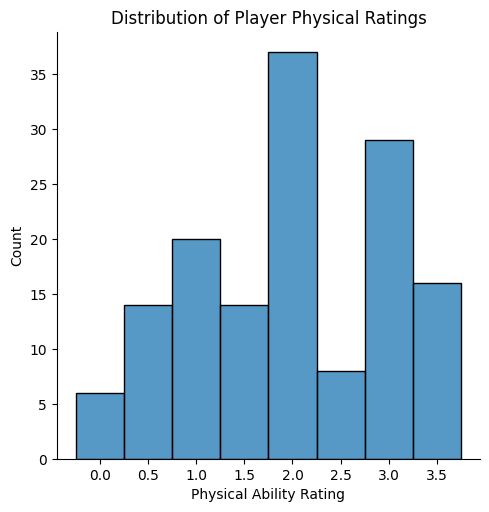

In [5]:
sns.displot(
    data=player_df,
    x='rating',
    bins=[-0.25, 0.25, 0.75, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75]
)

plt.title('Distribution of Player Physical Ratings')
plt.xlabel('Physical Ability Rating')
plt.ylabel('Count')
plt.show()

In [6]:
stint_df_copy = stint_df.copy()

stint_df_copy['total_goals'] = stint_df_copy['h_goals'] + stint_df['a_goals']
game_totals = stint_df_copy.groupby('game_id')['total_goals'].sum()
avg_goals_per_game = game_totals.mean()

print(f"Average number of goals scored per game {avg_goals_per_game}")

Average number of goals scored per game 99.59848484848484


In [7]:
stint_df_copy = stint_df.copy()

game_totals_per_team_df = stint_df_copy.groupby('game_id')[['h_goals', 'a_goals']].sum()
game_totals_per_team_df['did_h_win?'] = game_totals_per_team_df['h_goals'] > game_totals_per_team_df['a_goals']
home_team_wins = game_totals_per_team_df['did_h_win?'].sum()

print(f'On average: home team wins {(home_team_wins/game_totals_per_team_df.shape[0])*100}% of games')

On average: home team wins 57.12121212121212% of games


### Raw Plus Minus Scores for Athletes

In [8]:
stint_df["h_plus_minus"] = stint_df["h_goals"] - stint_df["a_goals"]
stint_df["a_plus_minus"] = -1*stint_df["h_plus_minus"]

player_df["minutes"] = 0
player_df["plus_minus"] = 0
player_cols = ["home1", "home2", "home3", "home4", "away1", "away2", "away3", "away4"]

stint_long = stint_df.melt(
    id_vars=["minutes", "h_plus_minus", "a_plus_minus"],
    value_vars=player_cols,
    var_name="team_player",
    value_name="player"
)

stint_long["plus_minus"] = stint_long.apply(
    lambda row: row["h_plus_minus"] if row["team_player"].startswith("home") else row["a_plus_minus"],
    axis=1
)

player_stats = stint_long.groupby("player").agg(
    total_minutes=("minutes", "sum"),
    total_plus_minus=("plus_minus", "sum")
).reset_index()

player_df = player_df.merge(player_stats, on="player", how="left", suffixes=("", "_new"))

player_df["minutes"] += player_df["total_minutes"].fillna(0)
player_df["plus_minus"] += player_df["total_plus_minus"].fillna(0)

player_df.drop(columns=["total_minutes", "total_plus_minus"], inplace=True)

player_df["plus_minus_per_minute"] = player_df["plus_minus"] / player_df["minutes"]

player_df["team"] = player_df["player"].str.split('_').str[0]

player_df.head()

,player,rating,minutes,plus_minus,plus_minus_per_minute,team
0,USA_p1,3.0,1155.774143,496,0.429150,USA
1,USA_p2,3.0,1067.953325,104,0.097383,USA
2,USA_p3,3.5,888.478357,285,0.320773,USA
3,USA_p4,0.0,1421.401843,136,0.095680,USA
4,USA_p5,2.0,1039.289768,275,0.264604,USA


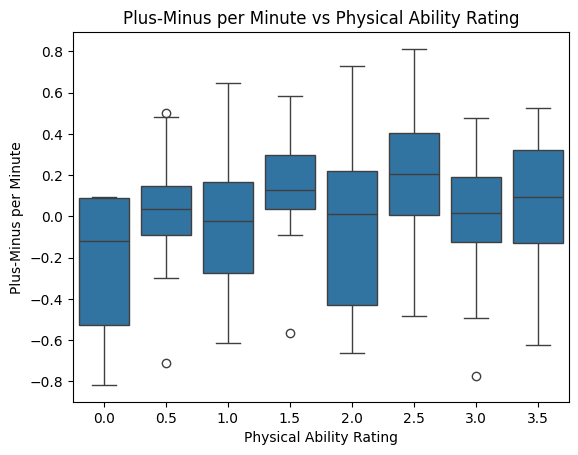

In [9]:
sns.boxplot(
    data=player_df,
    x='rating',
    y='plus_minus_per_minute',
)

plt.title('Plus-Minus per Minute vs Physical Ability Rating')
plt.xlabel('Physical Ability Rating')
plt.ylabel('Plus-Minus per Minute')
plt.show()

### Prediction

\begin{align}
X_{ij} = \begin{cases}
    1,  &\text{if player } j \text{ is on-court for the home team during stint } i \\
    -1,  &\text{if player } j \text{ is on-court for the away team during stint } i\\
    0,  &\text{otherwise.}
\end{cases}
\end{align}

\begin{align}
    y_{i} &= \alpha + \sum_{j} \beta_{j} X_{ij} + \epsilon_i \\
    \epsilon_i &\sim N(0, \sigma^2)
\end{align}

In [10]:
X = pd.DataFrame(0, index=stint_df.index, columns=player_df['player'].tolist())

player_cols = ["home1", "home2", "home3", "home4", "away1", "away2", "away3", "away4"]

for i, stint in stint_df.iterrows():
    for player in player_cols:
        X.loc[i, stint[player]] = 1 if player.startswith("home") else -1

X.fillna(0, inplace=True)

X

,USA_p1,USA_p2,USA_p3,USA_p4,USA_p5,USA_p6,USA_p7,USA_p8,USA_p9,USA_p10,...,Chile_p3,Chile_p4,Chile_p5,Chile_p6,Chile_p7,Chile_p8,Chile_p9,Chile_p10,Chile_p11,Chile_p12
0,1,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7443,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
7444,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
7445,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,0,0,0,0,0
7446,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,1,0


In [11]:
y = (stint_df['h_goals'] - stint_df['a_goals'])/ stint_df['minutes']
y

0      -1.175649
1      -0.878919
2      -0.869901
3       0.569538
4       0.924582
          ...   
7443    1.548529
7444    0.962416
7445    1.876145
7446   -1.822401
7447    1.363385
Length: 7448, dtype: float64

In [12]:
from sklearn.linear_model import RidgeCV
import numpy as np

alphas = np.logspace(-3,3,50)

ridge_model = RidgeCV(alphas=alphas, cv=5)
ridge_model.fit(X,y)

r2 = ridge_model.score(X,y)
print(f"R^2 Score: {r2}")
print(f"Best alpha: {ridge_model.alpha_}")

beta_values = ridge_model.coef_

player_df['APM'] = beta_values

best_player = player_df.loc[player_df['APM'].idxmax(), ['player', 'APM']]
worst_player = player_df.loc[player_df['APM'].idxmin(), ['player', 'APM']]

print("\nBest player (highest APM):")
print(best_player)

print("\nWorst player (lowest APM):")
print(worst_player)

R^2 Score: 0.03966639555547735
Best alpha: 429.1934260128778

Best player (highest APM):
player      USA_p3
APM       0.343453
Name: 2, dtype: object

Worst player (lowest APM):
player    Canada_p4
APM        -0.39233
Name: 39, dtype: object


In [13]:
print(player_df['player'])
print(pd.DataFrame(beta_values))

0         USA_p1
1         USA_p2
2         USA_p3
3         USA_p4
4         USA_p5
         ...    
139     Chile_p8
140     Chile_p9
141    Chile_p10
142    Chile_p11
143    Chile_p12
Name: player, Length: 144, dtype: object
            0
0    0.067256
1    0.208881
2    0.343453
3   -0.159443
4   -0.071564
..        ...
139 -0.088757
140 -0.007390
141 -0.154366
142 -0.031870
143  0.039997

[144 rows x 1 columns]


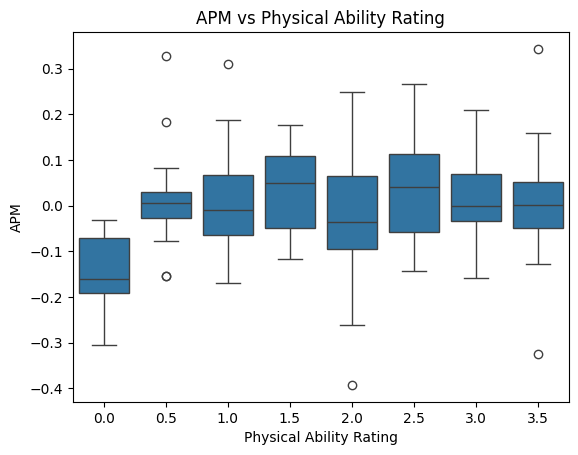

In [14]:
sns.boxplot(
    data=player_df,
    x='rating',
    y='APM'
)

plt.title('APM vs Physical Ability Rating')
plt.xlabel('Physical Ability Rating')
plt.ylabel('APM')
plt.show()

In [15]:
intercept = ridge_model.intercept_
print(f"Intercept is: {intercept}. Signifies that home team on average socres 0.0585 more goals per minute than away teams")

Intercept is: 0.058509998034988075. Signifies that home team on average socres 0.0585 more goals per minute than away teams


### Optimization

In [16]:
canada = player_df[player_df['team'] == 'Canada']
canada = canada.drop(columns=['minutes', 'plus_minus', 'plus_minus_per_minute', 'team'])
canada = canada.reset_index(drop=True)

In [17]:
canada.sort_values(by='APM')

,player,rating,APM
3,Canada_p4,2.0,-0.392330
4,Canada_p5,3.5,-0.323554
1,Canada_p2,0.0,-0.304414
2,Canada_p3,2.0,-0.130221
0,Canada_p1,3.0,-0.045006
7,Canada_p8,3.5,-0.042269
11,Canada_p12,0.5,-0.000370
9,Canada_p10,1.0,0.048766
5,Canada_p6,1.5,0.059078
6,Canada_p7,3.0,0.072802


In [18]:
canada

,player,rating,APM
0,Canada_p1,3.0,-0.045006
1,Canada_p2,0.0,-0.304414
2,Canada_p3,2.0,-0.130221
3,Canada_p4,2.0,-0.392330
4,Canada_p5,3.5,-0.323554
5,Canada_p6,1.5,0.059078
6,Canada_p7,3.0,0.072802
7,Canada_p8,3.5,-0.042269
8,Canada_p9,2.5,0.180896
9,Canada_p10,1.0,0.048766


### IP Knapsack Model: Optimal Lineup

\begin{align}
        \textrm{maximize} \quad   & \sum_{j \in R} \beta_j x_j  \\
        \textrm{subject to} \quad  & \sum_{j \in R} w_jx_j \leq 8\\
              & \sum_{j \in R} x_j = 4\\
              & x_j \in \{0,1\}, \quad \forall j \in R.
\end{align}

In [19]:
ratings = canada['rating']
betas = canada['APM']

x = cp.Variable(len(canada), boolean=True)

cons = [
    x@ratings <= 8,
    x@np.ones(len(canada)) == 4
]

obj = cp.Maximize(x@betas)
prob = cp.Problem(obj, cons)
prob.solve()

Restricted license - for non-production use only - expires 2026-11-23


0.5383775966425791

### LP Model: Optimal Play Time Allocation

\begin{aligned}
        \max & \left( \sum_{i \in P} Z_i + \sum_{i \in N} Q_i \right) \\
        s.t. \quad & Z_i \leq (m^k_it_i + d^k_i) \quad \forall i \in P,k \\
        & Q_i \leq (c^k_it_i + d^k_i) \quad \forall i \in N,k \\
        & t_i \geq 0 \quad \forall i \\
        & t_i \leq 32 \quad \forall i \\
        & \sum_{i} t_i = 128\\
\end{aligned}

In [20]:
m = [1, 0.75, 0.5, 0.25]
b = [0, 1.5, 4.5, 10.5]
c = [1, 1.25, 1.5, 1.75]
d = [0, -1.5, -4.5, -10.5]

P = [5,6,8,9,10] 
N = [0,1,2,3,4,7,11] 
K = 4

t = cp.Variable(12) 
Z = cp.Variable(len(P)) 
Q = cp.Variable(len(N)) 

obj = cp.Maximize(sum(Z) + sum(Q))

cons = [
  sum(t) == 128,
  t >= 0,
  t <= 32
]

ind = 0  
for i in P:
  for k in range(K):
    cons.append(Z[ind] <= canada.iloc[i]['APM'] * (m[k]*t[i] + b[k]))
  ind = ind + 1  

ind = 0 
for i in N:
  for k in range(K):
    cons.append(Q[ind] <= canada.iloc[i]['APM'] * (c[k]*t[i] + d[k]))
  ind = ind + 1 

prob = cp.Problem(obj,cons)
prob.solve()

prob.solve(verbose=True)  
print(f"The total APM is {obj.value:.3f}")

t_np_array = t.value.astype(float)
t_values = pd.Series(np.round(t_np_array, 2), index=canada.player)
print(f"The optimal playing time allocation per player is:\n{t_values}")

(CVXPY) Oct 22 04:55:37 PM: Your problem has 24 variables, 73 constraints, and 0 parameters.
(CVXPY) Oct 22 04:55:37 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 22 04:55:37 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Oct 22 04:55:37 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Oct 22 04:55:37 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Oct 22 04:55:37 PM: Using cached ASA map, for faster compilation (bypassing reduction chain).
(CVXPY) Oct 22 04:55:37 PM: Finished problem compilation (took 8.099e-04 seconds).
(CVXPY) Oct 22 04:55:37 PM: Invoking solver CLARABEL  to obtain a solution.


                                     CVXPY                                     
                                     v1.7.3                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
-------------------------------------------------------------
           Clarabel.rs v0.11.1  -  Clever Acronym                

                   (c) Paul Goulart                          
                University of Oxford, 2022                   
-------------------------------------------------------------

problem:
  variables     = 24
  constraints 

(CVXPY) Oct 22 04:55:37 PM: Problem status: optimal
(CVXPY) Oct 22 04:55:37 PM: Optimal value: 1.075e+01
(CVXPY) Oct 22 04:55:37 PM: Compilation took 8.099e-04 seconds
(CVXPY) Oct 22 04:55:37 PM: Solver (including time spent in interface) took 2.676e-03 seconds


  0  +6.5073e+00  -4.9519e+02  7.71e+01  4.99e-02  3.43e-01  1.00e+00  8.42e+00   ------   
  1  +1.1044e+01  -5.0456e+01  5.57e+00  6.25e-03  5.03e-02  1.18e-01  1.16e+00  8.64e-01  
  2  -2.6956e+00  -2.5682e+01  8.53e+00  2.22e-03  1.62e-02  9.25e-02  4.47e-01  6.75e-01  
  3  -8.7878e+00  -1.5334e+01  7.45e-01  5.98e-04  4.01e-03  3.04e-02  1.30e-01  7.26e-01  
  4  -9.8909e+00  -1.2532e+01  2.67e-01  2.35e-04  1.51e-03  1.69e-02  5.23e-02  6.68e-01  
  5  -1.0618e+01  -1.0968e+01  3.30e-02  3.08e-05  1.94e-04  2.70e-03  6.94e-03  8.88e-01  
  6  -1.0732e+01  -1.0788e+01  5.15e-03  4.85e-06  3.03e-05  4.91e-04  1.10e-03  8.69e-01  
  7  -1.0749e+01  -1.0755e+01  5.95e-04  5.62e-07  3.51e-06  7.40e-05  1.27e-04  9.39e-01  
  8  -1.0750e+01  -1.0751e+01  2.24e-05  2.12e-08  1.32e-07  3.30e-06  4.79e-06  9.90e-01  
  9  -1.0750e+01  -1.0750e+01  2.24e-07  2.12e-10  1.32e-09  3.30e-08  4.79e-08  9.90e-01  
 10  -1.0750e+01  -1.0750e+01  2.24e-09  2.12e-12  1.32e-11  3.30e-10  4.79e-10 

In [21]:
ratings_arr = canada['rating']

idx_35 = np.where(ratings_arr == 3.5)[0]  
idx_05 = np.where(ratings_arr == 0.5)[0]   

idx_30 = np.where(ratings_arr == 3.0)[0]   
idx_10 = np.where(ratings_arr == 1.0)[0]  

cons.append(cp.sum(t[idx_35]) == cp.sum(t[idx_05]))
cons.append(cp.sum(t[idx_30]) == cp.sum(t[idx_10]))

prob = cp.Problem(obj,cons)
prob.solve()

10.70922535061572

In [22]:
cons.append(t >= 4)

prob = cp.Problem(obj,cons)
prob.solve()

4.688925782150075